## Predict Stock Market Closing Day Prices

### Import Libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy import newaxis
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
from keras.optimizers import Adam
import livelossplot
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


### Load Data

In [95]:
def load_data(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    result = normalise_windows(result)

    result = np.array(result)
#     scaler = MinMaxScaler(feature_range=(0,1))
#     result = scaler.fit_transform(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

- Normalize the window of data

n = normalised list (window) of price changes

p = raw list (window) of adjusted daily return prices

Normalisation: ni = (pi - min)/(max - min)

De-Normalisation: pi = ni*(max - min) + min

In [96]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        min_val = np.amin(window)
        max_val = np.amax(window)
        if max_val - min_val != 0:
            normalised_window = [(float(p - min_val) / float(max_val - min_val)) for p in window]
        else:
            normalised_window = window
        normalised_data.append(normalised_window)
    return normalised_data

### Build Model

- Build a model with two layers of LSTM and one layer of Dense created by Keras
- Uses Adam optimizer and Mean Squared Error for loss function

In [97]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(return_sequences=True, input_shape=(None,layers[0]), units=layers[1]))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
    
    model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
    print("> Compilation Time : ", time.time() - start)
    return model

### Prediction

- Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time

In [98]:
def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

- Shift the window by 1 new prediction each time, re-run predictions on new window

In [99]:
def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

- Predict sequence of prediction_len steps before shifting prediction run forward by prediction_len steps

In [100]:
def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

### Plot

- Plot prediction against true data

In [101]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

- Plot the results given amount of steps ahead of time

In [102]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

### Test Model

In [103]:
global_start_time = time.time()
epochs  = 50
seq_len = 50

X_train = []
y_train = []
X_test = []
y_test = []

X_temp = []
y_temp = []
X_temp2 = []
y_temp2 = []

df = pd.read_csv('all_features.csv', sep=',')

iterdf = iter(df)
next(iterdf)
next(iterdf)

scaler_closing = MinMaxScaler(feature_range=(0,1))
closing = np.array(df['Close']).reshape(-1, 1)
closing = scaler_closing.fit_transform(closing)

for index, column in enumerate(iterdf):
    X_temp, y_temp, X_temp2, y_temp2 = load_data(df[column].values, seq_len)
    X_train.append(X_temp)
    y_train.append(y_temp)
    X_test.append(X_temp2)
    y_test.append(y_temp2)

num_train = len(X_train[0])
num_indicators = len(X_train)
num_test = len(X_test[0])

X_train = np.array(X_train).reshape(num_train, seq_len, num_indicators)
y_train = np.array(y_train[3])
X_test = np.array(X_test).reshape(num_test, seq_len, num_indicators)

model = build_model([60, 512, 1024, 1])

model.summary()

plot_losses = livelossplot.PlotLossesKeras()

> Compilation Time :  0.023453950881958008
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, None, 512)         1173504   
_________________________________________________________________
dropout_29 (Dropout)         (None, None, 512)         0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 1024)              6295552   
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 1025      
_________________________________________________________________
activation_15 (Activation)   (None, 1)                 0         
Total params: 7,470,081
Trainable params: 7,470,081
Non-trainable params: 0
_______________________

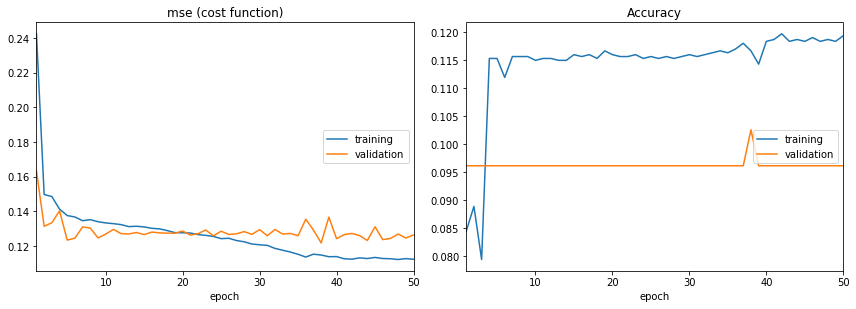

Training duration (s) :  2738.092711210251


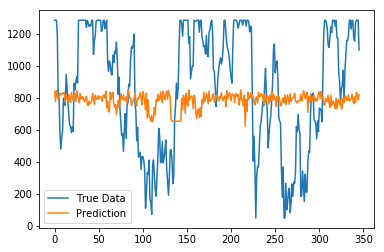

In [104]:
model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.05, callbacks=[plot_losses])

model.save('indicator_model.h5')

model.save_weights('indicator_model_weights.h5')

predicted = model.predict(X_test)
# scale back 
predicted = scaler_closing.inverse_transform(predicted)
y_test = scaler_closing.inverse_transform(y_test)
predicted = np.reshape(predicted, (predicted.size,))
y_test = np.array(y_test[3])

print('Training duration (s) : ', time.time() - global_start_time)

plot_results(predicted, y_test)

- Shift the window by 1 new prediction each time, re-run predictions on new window

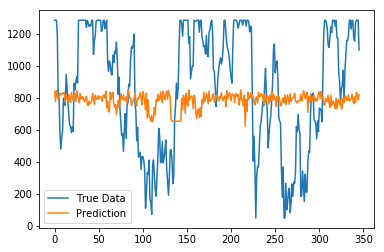

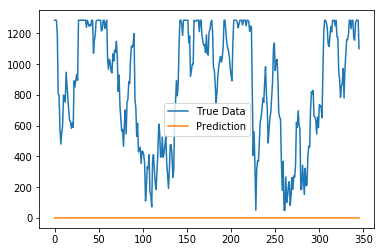

In [105]:
predict_full = predict_sequence_full(model, X_test, seq_len)
plot_results(predict_full, y_test)

- Predict 50 time steps ahead

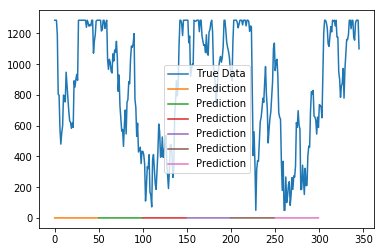

In [106]:
predictions = predict_sequences_multiple(model, X_test, seq_len, 50)
plot_results_multiple(predictions, y_test, 50)